### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [2]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [3]:
# get all unique characters from lines (including capital letters and symbols)
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
tokens = set()
for w in ' '. join(lines):
    letters = tokenizer.tokenize(w)
    for letter in letters:
        tokens.add(letter)
tokens.add(BOS)
tokens.add(EOS)
#tokens = ([' '.join() for sent in ' '. join(lines)])

#tokens = <YOUR CODE>

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with it's index in tokens list. This way we can encode a string into a TF-friendly integer vector.

In [4]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {w:i for i, w in enumerate(tokens)}

In [5]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integet matrix `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra _EOS_ or cropping long sequences. Here's how it works:

In [6]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype='int32'):
    """Casts a list of lines into tf-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [26]:
#Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))



[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [8]:
import tensorflow as tf
import keras, keras.layers as L
sess = tf.InteractiveSession()

Using TensorFlow backend.


In [9]:
emb_size=16
hid_size=64
emb = L.Embedding(emb_size, hid_size)

l_input = L.Input(shape=[emb_size])

seq = tf.placeholder('int32', [None, None])



f = emb(seq)
#f = L.Convolution1D(filters=32, kernel_size=2, padding='same', activation='relu')(f)
#f = L.Convolution1D(filters=136, kernel_size=1)(f)

sess.run(tf.global_variables_initializer())
ans = sess.run(f, {seq:to_matrix(dummy_lines)})
ans.shape

(3, 15, 64)

In [15]:
class FixedWindowLanguageModel:
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        
        You can stack several convolutions at once
        """
        
        #YOUR CODE - create layers/variables and any metadata you want, e.g. self.emb = L.Embedding(...)
        
        self.emb = L.Embedding(emb_size, hid_size)
        self.c1 = L.Convolution1D(filters=32, kernel_size=2, padding='same', activation='relu')
        self.c2 = L.Convolution1D(filters=n_tokens, kernel_size=1)
        self.emb_size = emb_size
        
        tf.local_variables_initializer()
        #END OF YOUR CODE
        
        self.prefix_ix = tf.placeholder('int32', [None, None])
        self.next_token_probs = tf.nn.softmax(self(self.prefix_ix)[:, -1])
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        tf.local_variables_initializer()
        f = emb(input_ix)
        text = self.c1(f)
        text = self.c2(text)
        
        return text
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100, sess=sess):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        probs = sess.run(self.next_token_probs, {self.prefix_ix: to_matrix([prefix])})[0]
        return dict(zip(tokens, probs))
        

In [16]:
window_lm = FixedWindowLanguageModel()

In [17]:
dummy_input_ix = tf.constant(to_matrix(dummy_lines))
dummy_lm_out = window_lm(dummy_input_ix)
# note: tensorflow and keras layers only create variables after they're first applied (called)

sess.run(tf.global_variables_initializer())
dummy_logits = sess.run(dummy_lm_out)

#print( dummy_logits.shape, (len(dummy_lines), max(map(len, dummy_lines)), n_tokens))
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits)), "inf/nan encountered"
assert not np.allclose(dummy_logits.sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [18]:
# test for lookahead
dummy_input_ix_2 = tf.constant(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_lm_out_2 = window_lm(dummy_input_ix_2)
dummy_logits_2 = sess.run(dummy_lm_out_2)
assert np.allclose(dummy_logits[:, :3] - dummy_logits_2[:, :3], 0), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [19]:
def compute_lengths(input_ix, eos_ix=token_to_id[EOS]):
    """ compute length of each line in input ix (incl. first EOS), int32 vector of shape [batch_size] """
    count_eos = tf.cumsum(tf.to_int32(tf.equal(input_ix, eos_ix)), axis=1, exclusive=True)
    lengths = tf.reduce_sum(tf.to_int32(tf.equal(count_eos, 0)), axis=1)
    return lengths

print('matrix:\n', dummy_input_ix.eval())
print('lengths:', compute_lengths(dummy_input_ix).eval().shape)

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
lengths: (3,)


In [20]:
##
dummy_logits_2.shape

(3, 15, 136)

In [63]:
tf.shape(logits)

<tf.Tensor 'Shape_3:0' shape=(3,) dtype=int32>

In [22]:
[line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]

[' abee', ' abeeeeee', ' abeeeeeeeeeeee']

In [ ]:
tf.sequence_mask(logits, 136)

## How implement LOOPS in tf?? If I am not initialize "reference_answers"...imposible to compile!

In [77]:
def my_loss(reference_answers, logits):
    lengths = compute_lengths(reference_answers)
    s = tf.Variable(initial_value=0.0, name="sum")
    for i in tf.range(tf.shape(lengths)[0]):
        for j in tf.range(lengths[i]):
            s += -tf.log(logits[i][j][reference_answers[i][j]])
    return s / tf.reduce_sum(lengths)
        

In [94]:
def my_loss2(reference_answers, logits, logits_size=[3,15,136]):
    nsent, nwords, nsymb = logits_size
    s = tf.Variable(initial_value=0.0, name="sum")
    lengths = compute_lengths(reference_answers)
    real_words = tf.to_float(tf.sequence_mask(lengths, nwords))
    reference_answers = tf.to_float(tf.one_hot(reference_answers, nsymb))
    s += -tf.reduce_sum(tf.log(tf.reduce_sum(reference_answers * logits, axis=2) * real_words))
    return s / tf.to_float(tf.reduce_sum(lengths))

In [115]:
tf.concat(tf.to_int32(tf.shape(tf.Variable(ans_test))), 3).eval()
#tf.Variable(np.array([136,]))

array([ 3, 14], dtype=int32)

In [102]:
##
input_ix = tf.placeholder('int32', [None, None], name='inpt')

logits = window_lm(input_ix[:, :-1])
reference_answers = input_ix[:, 1:]

to_matrix(dummy_lines, max_len=50)

#tf.shape(logits)
#tf.sequence_mask(logits, reference_answers)
logits_size = tf.shape(input_ix[:, :-1]).eval()
L = my_loss2(reference_answers, logits, logits_size.append(n_tokens))

InvalidArgumentError: You must feed a value for placeholder tensor 'inpt_16' with dtype int32 and shape [?,?]
	 [[Node: inpt_16 = Placeholder[dtype=DT_INT32, shape=[?,?], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: Shape_8/_207 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_13_Shape_8", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'inpt_16', defined at:
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 346, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 259, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 513, in execute_request
    user_expressions, allow_stdin,
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-102-a9034de89239>", line 2, in <module>
    input_ix = tf.placeholder('int32', [None, None], name='inpt')
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1735, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4925, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'inpt_16' with dtype int32 and shape [?,?]
	 [[Node: inpt_16 = Placeholder[dtype=DT_INT32, shape=[?,?], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: Shape_8/_207 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_13_Shape_8", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [57]:
lengths = compute_lengths(to_matrix(dummy_lines))#reference_answers)
tf.sequence_mask(lengths, 15).eval()

array([[ True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]])

In [48]:
ans_test = to_matrix(dummy_lines)[:, 1:]
tf.sequence_mask(ans_test, n_tokens).eval()[0][1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [52]:
a = np.array([1,2,3,0])
tf.sequence_mask(a, 3).eval(), tf.one_hot(a, 4).eval()

(array([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True],
        [False, False, False]]), array([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.]], dtype=float32))

In [34]:
loss = 
sess.run(logits, {input_ix: to_matrix(dummy_lines, max_len=50)}).shape

(3, 49, 136)

In [ ]:
tf.one_hot(a, 4).eval()

In [28]:
def my_loss3(reference_answers, logits):
    prob = tf.reduce_sum(tf.to_float(tf.sequence_mask(reference_answers, n_tokens)) * logits, axis=2)
    sum = tf.reduce_sum(-tf.log(prob))
    lengths = compute_lengths(reference_answers)
    return sum / tf.to_float(tf.reduce_sum(lengths))

In [19]:
tf.reduce_sum(tf.to_float(tf.sequence_mask(reference_answers, n_tokens)) * logits, axis=2)

<tf.Tensor 'Sum_3:0' shape=(?, ?) dtype=float32>

In [87]:
input_ix = tf.placeholder('int32', [None, None])

logits = window_lm(input_ix[:, :-1])  ## its take all except last simbol, why for chesk we need from 1 to end (not only last??) 
reference_answers = input_ix[:, 1:]

# Your task: implement loss function as per formula above
# your loss should only be computed on actual tokens, excluding padding
# predicting actual tokens and first EOS do count. Subsequent EOS-es don't
# you will likely need to use compute_lengths and/or tf.sequence_mask to get it right.

loss = my_loss2(reference_answers, logits)# tf.losses.softmax_cross_entropy(tf.sequence_mask(reference_answers, n_tokens), logits)

optimizer = tf.train.GradientDescentOptimizer(0.01)
train_step = optimizer.minimize(loss)

In [91]:
sess.run(tf.initialize_local_variables())
sess.run(tf.initialize_all_variables())
sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=50)})

Instructions for updating:
Use `tf.global_variables_initializer` instead.


InvalidArgumentError: Incompatible shapes: [3,49] vs. [3,15]
	 [[Node: mul_16 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Sum_46, ToFloat_15)]]
	 [[Node: truediv_4/_177 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_118_truediv_4", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'mul_16', defined at:
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 346, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 259, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 513, in execute_request
    user_expressions, allow_stdin,
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-87-bf23c1bd655f>", line 11, in <module>
    loss = my_loss2(reference_answers, logits)# tf.losses.softmax_cross_entropy(tf.sequence_mask(reference_answers, n_tokens), logits)
  File "<ipython-input-82-b2c83218ad02>", line 7, in my_loss2
    s += -tf.reduce_sum(tf.log(tf.reduce_sum(reference_answers * logits, axis=2) * real_words))
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 850, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1094, in _mul_dispatch
    return gen_math_ops.mul(x, y, name=name)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 4936, in mul
    "Mul", x=x, y=y, name=name)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/denis/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [3,49] vs. [3,15]
	 [[Node: mul_16 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Sum_46, ToFloat_15)]]
	 [[Node: truediv_4/_177 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_118_truediv_4", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [100]:
loss_1 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=50)})
loss_2 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=100)})
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert np.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use tf.sequence_mask. Beware +/-1 errors. And be careful when averaging!'

AssertionError: loss must be a positive scalar

### Training loop

Now let's train our model on minibatches of data

In [80]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

sess.run(tf.global_variables_initializer())
batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []

In [81]:
def score_lines(dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    for i in range(0, len(dev_lines), batch_size):
        batch_ix = to_matrix(dev_lines[i: i + batch_size])
        dev_loss_num += sess.run(loss, {input_ix: batch_ix}) * len(batch_ix)
        dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(lm, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by lm
    :param temperature: samples proportionally to lm probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    while True:
        token_probs = lm.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        if temperature == 0:
            next_token = tokens[np.argmax(probs)]
        else:
            probs = np.array([p ** (1. / temperature) for p in probs])
            probs /= sum(probs)
            next_token = np.random.choice(tokens, p=probs)
        
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

if len(dev_history) == 0:
    dev_history.append((0, score_lines(dev_lines, batch_size)))
    print("Before training:", generate(window_lm, 'Bridging'))

Before training: Bridging%ïΣ="ωp



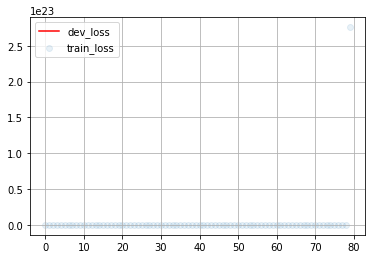

 76%|███████▌  | 3800/5000 [16:08<05:27,  3.67it/s]

Generated examples (tau=0.5):
 

 

 



 77%|███████▋  | 3849/5000 [16:19<04:09,  4.61it/s]

KeyboardInterrupt: 

In [83]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    loss_i, _ = sess.run([loss, train_step], {input_ix: batch})
    train_history.append((i, loss_i))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for j in range(3):
            print(generate(window_lm, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(window_lm, temperature=0.5))

### RNN Language Models

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [ ]:
class RNNLanguageModel:
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        """
        
        # YOUR CODE - create layers/variables/etc
        
        <...>
        
        #END OF YOUR CODE
        
        
        self.prefix_ix = tf.placeholder('int32', [None, None])
        self.next_token_probs = tf.nn.softmax(self(self.prefix_ix)[:, -1])
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        #YOUR CODE
        return <...>
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100, sess=sess):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        probs = sess.run(self.next_token_probs, {self.prefix_ix: to_matrix([prefix])})[0]
        return dict(zip(tokens, probs))
        

In [ ]:
rnn_lm = RNNLanguageModel()

In [ ]:
dummy_input_ix = tf.constant(to_matrix(dummy_lines))
dummy_lm_out = rnn_lm(dummy_input_ix)
# note: tensorflow and keras layers only create variables after they're first applied (called)

sess.run(tf.global_variables_initializer())
dummy_logits = sess.run(dummy_lm_out)

assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits)), "inf/nan encountered"
assert not np.allclose(dummy_logits.sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [ ]:
# test for lookahead
dummy_input_ix_2 = tf.constant(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_lm_out_2 = rnn_lm(dummy_input_ix_2)
dummy_logits_2 = sess.run(dummy_lm_out_2)
assert np.allclose(dummy_logits[:, :3] - dummy_logits_2[:, :3], 0), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [breaking](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/clip_by_global_norm).

Your task here is to prepare tensorflow graph that would minimize the same loss function. If you encounter large loss fluctuations during training, please add gradient clipping using urls above.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [ ]:
input_ix = tf.placeholder('int32', [None, None])

logits = rnn_lm(input_ix[:, :-1])
reference_answers = input_ix[:, 1:]

# Copy the loss function and train step from the fixed-window model training
loss = <...>

# and the train step
train_step = <...>

In [ ]:
loss_1 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=50)})
loss_2 = sess.run(loss, {input_ix: to_matrix(dummy_lines, max_len=100)})
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert np.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. Hint: use tf.sequence_mask. Be careful when averaging!'

### RNN: Training loop

In [ ]:
sess.run(tf.global_variables_initializer())
batch_size = 128
score_dev_every = 250
train_history, dev_history = [], []

dev_history.append((0, score_lines(dev_lines, batch_size)))

In [ ]:
for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    loss_i, _ = sess.run([loss, train_step], {input_ix: batch})
    train_history.append((i, loss_i))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for j in range(3):
            print(generate(rnn_lm, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [ ]:
assert np.mean(train_history[:10]) > np.mean(train_history[-10:]), "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(rnn_lm, temperature=0.5))

### Bonus quest: Ultimate Language Model

So you've learned the building blocks of neural language models, you can now build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;

_You are NOT required to submit this assignment. Please make sure you don't miss your deadline because of it :)_